<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Make-counterfactual-graph" data-toc-modified-id="Make-counterfactual-graph-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Make counterfactual graph</a></span></li>
    <li><span><a href="#Preliminaries" data-toc-modified-id="Preliminaries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preliminaries</a></span></li> 
    <li><span><a href="#Example-of-using-make_counterfactual_graph" data-toc-modified-id="Example-of-using-make_counterfactual_graph-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Example of using make_counterfactual_graph</a></span></li>
    <li><span><a href="#Walkthrough-of-make-counterfactual-graph" data-toc-modified-id="Walkthrough-of-make-counterfactual-graph-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Walkthrough of make counterfactual graph</a></span></li>
    <ul>
    <li><span><a href="#Starting-graph-(Figure-9a)" data-toc-modified-id="Starting-graph-(Figure-9a)-3"><span class="toc-item-num">&nbsp;&nbsp;</span>Starting graph (Figure 9a)</a></span></li>
    <li><span><a href="#First-Step:-Make-Parallel-worlds-graph" data-toc-modified-id="First-Step:-Make-Parallel-worlds-graph-4"><span class="toc-item-num">&nbsp;&nbsp;</span>First Step: Make Parallel worlds graph</a></span></li>
    <li><span><a href="#Merging-the-Parallel-Worlds" data-toc-modified-id="Merging-the-Parallel-Worlds-5"><span class="toc-item-num">&nbsp;&nbsp;</span>Merging the Parallel Worlds</a></span></li>
    <li><span><a href="#Figure-11a-Checkpoint" data-toc-modified-id="Figure-11a-Checkpoint-6"><span class="toc-item-num">&nbsp;&nbsp;</span>Figure 11a Checkpoint</a></span></li>
    <li><span><a href="#Merging-nodes-with-different-parents" data-toc-modified-id="Merging-nodes-with-different-parents-7"><span class="toc-item-num">&nbsp;&nbsp;</span>Merging nodes with different parents</a></span></li>
    <li><span><a href="#Figure-11b-Checkpoint" data-toc-modified-id="Figure-11b-Checkpoint-8"><span class="toc-item-num">&nbsp;&nbsp;</span>Figure 11b Checkpoint</a></span></li>
    <li><span><a href="#Figure-11c-Checkpoint" data-toc-modified-id="Figure-11c-Checkpoint-9"><span class="toc-item-num">&nbsp;&nbsp;</span>Figure 11c Checkpoint</a></span></li>
    <li><span><a href="#Return-only-the-ancestors-of-events" data-toc-modified-id="Return only the ancestors of events-10"><span class="toc-item-num">&nbsp;&nbsp;</span>Return only the ancestors of events</a></span></li>
    <li><span><a href="#Figure-9c-Checkpoint" data-toc-modified-id="Figure-9c-Checkpoint-11"><span class="toc-item-num">&nbsp;&nbsp;</span>Figure 9c Checkpoint</a></span></li>
    <li><span><a href="#Final-Checkpoint" data-toc-modified-id="Final-Checkpoint-12"><span class="toc-item-num">&nbsp;&nbsp;</span>Final Checkpoint</a></span></li>
    </ul>
    <li><span><a href="#More-Examples-of-make_counterfactual_graph" data-toc-modified-id="More-Examples-of-make_counterfactual_graph-13"><span class="toc-item-num">5&nbsp;&nbsp;</span>More Examples of make_counterfactual_graph</a></span></li>
    </ul></div>

# Make counterfactual graph

The **make-cg** algorithm operates by taking a causal diagram $G$ and a conjunction of counterfactual events $\gamma$ as inputs. It then proceeds to construct a counterfactual graph $G'$ and an associated conjunction of events $\gamma'$ (or **INCONSISTENT** if no consistent solution exists). The algorithm ensures that each counterfactual variable is unique and eliminates variables that do not impact the query. It represents an enhanced version of the parallel worlds graph, which generates a new counterfactual graph based on the original graph and counterfactual events, but lacks the simplification step of removing redundant variables and events.

$$\newcommand\ci{\perp\!\!\!\perp}$$
$$\newcommand{\ubar}[1]{\underset{\bar{}}{#1}}
\newcommand{\obar}[1]{\overset{\bar{}}{#1}}$$
# Preliminaries
The **make-cg** algorithm utilizes two Lemmas from (I. Shpitser, J. Pearl 2008) during the implementation. The first, Lemma 24, provides formal strucure for determining when two variables in the counterfactual graph represent the same random variable, and the second, Lemma 25, provides the necessary extension which shows that the two variables can be merged into a single variable.

**Lemma 24** Let $M$ be a model inducing $G$ containing variables $\alpha,\beta$ with the following properties: 
* $\alpha$ and $\beta$ have the same domain of values.
*  There is a bijection $f$ from $Pa(\alpha)$ to $Pa(\beta)$ such that a parent $\gamma$ and $f(\gamma)$ have the same domain of values. 
* The functional mechanisms of $\alpha$ and $\beta$ are the same (except whenever the function for $\alpha$ uses the parent $\gamma$, the corresponding function for $\beta$ uses $f (\gamma)$). 

Assume an observable variable set $\mathbf Z$ was observed to attain values $\mathbf{z}$ in $M_\mathbf{x}$, the submodel obtained from $M$ by forcing another observable variable set $\mathbf X$ to attain values $\mathbf x$. Assume further that for each $\gamma\in Pa(\alpha)$, either $f (\gamma) = \gamma$, or $\gamma$ and $f (\gamma)$ attain the same values (whether by observation or intervention). Then $\alpha$ and $\beta$ are the same random variable in $M_{\mathbf x}$ with observations $\mathbf z$.

$\textbf{Lemma 25}$. Let $M_\mathbf{x}$ be a submodel derived from $M$ with set $\mathbf Z$ observed to attain values $\mathbf z$, such that Lemma 24 holds for $\alpha, \beta$. Let $M'$ be a causal model obtained from $M$ by merging $\alpha, \beta$ into a new node $\omega$, which inherits all parents and the functional mechanism of $\alpha$. All children of $\alpha,\beta$ in $M'$ become children of $\omega$. Then $M_\mathbf{x}$,  $M'_\mathbf{x}$ agree on any distribution consistent with $\mathbf{z}$ being observed.



$\text{function }\mathbf{ make-cg}\left(G, \gamma\right) \\ \text{INPUT: } \text{ $G$ a causal diagram, $\gamma$ a conjunction of counterfactual events}. \\  \text{OUTPUT:  A counterfactual graph $G_\gamma$ and either a set of events $\gamma'$ such that $P(\gamma') = P(\gamma)$ or $\mathbf{Inconsistent}$} $

* Construct a submodel $G_{\mathbf{X}_i}$ for each action $do(\mathbf{x}_i)$ mentioned in $\gamma$. Construct the parallel worlds graph $G'$ by having all such graphs share their corresponding $U$ nodes.

* Let $\pi$ be a topological ordering of nodes in $G'$, let $\gamma':=\gamma.$
* Apply Lemmas 24 and 25, in order $\pi$ to each observable node pair $\alpha, \beta$ derived from the same variable in $G$. For each $\alpha, \beta$ that are the same, do:
    * Let $G'$ be modified as specified in Lemma 25
    * Modify $\gamma'$ by renaming all occurrences of $\beta$ to $\alpha$.
    * If $\mathbf{val}(\alpha)\neq \mathbf{val}(\beta)$, return $G', \mathbf{Inconsistent}$.
* $\texttt{return}$ $(G'_{An(\gamma')}, \gamma')$, where $An(\gamma')$ is the set of nodes in $G'$ ancestral to nodes corresponding to variables mentioned in $\gamma'$.

$$P(\lnot rxn_{do(\lnot catalyst)} | rxn, catalyst)$$

# Example of using make_counterfactual_graph
The walkthrough shows each step of the algorithm, but first here is an example of using make_counterfactual_graph with a simple graph and event.

The graph we are using is found in figure 9a from (I. Shpitser, J. Pearl 2008).

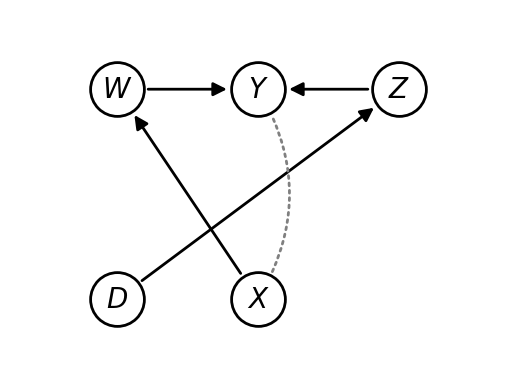

In [1]:
from y0.algorithm.identify.cg import make_counterfactual_graph
from y0.examples import figure_9a
from matplotlib import pyplot as plt
from y0.dsl import A, B, C, X, D, W, P, Y, Z

x, y, z, w, d = -X, -Y, -Z, -W, -D

figure_9a.graph.draw()  # This will be our starting graph

Event returned from make_counterfactual_graph {Y @ -X: -Y, X: +X, D: -D, Z: -Z},
here we note that Z @ -d: -z has changed to Z: -Z


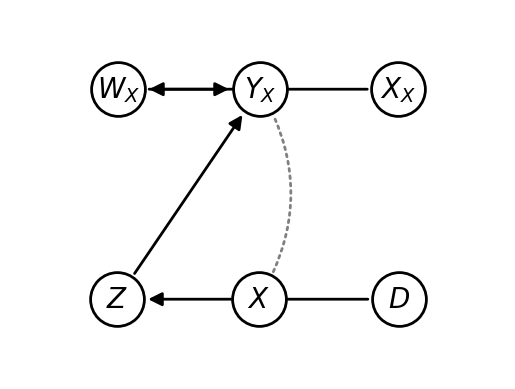

In [2]:
input_graph = figure_9a.graph
input_event = {Y @ -x: -y, X: +x, Z @ -d: -z, D: -d}
final_graph, final_event = make_counterfactual_graph(input_graph, input_event)
print(
    f"Event returned from make_counterfactual_graph {final_event},\nhere we note that Z @ -d: -z has changed to Z: -Z"
)
final_graph.draw()

In [3]:
# Imports needed for this make_counterfactual_graph walkthrough
%load_ext autoreload
%autoreload 2
from y0.algorithm.identify.cg import (
    make_parallel_worlds_graph,
    make_counterfactual_graph,
    lemma_24_holds,
    merge_pw,
    update_event,
)
from y0.examples import (
    figure_9a,
    figure_9b,
    figure_9c,
    figure_9d,
    figure_11a,
    figure_11b,
    figure_11c,
)
from matplotlib_inline.backend_inline import set_matplotlib_formats

set_matplotlib_formats("svg")

x, y, z, w, d = -X, -Y, -Z, -W, -D

# Walkthrough of make counterfactual graph

We illustrate the operation of make-cg by showing how the graph in Fig. 9 (c) is derived from the graph in Fig. 9 (a). We start the application of Lemma 24 from the topmost observable nodes, and conclude that the node pairs $D_x, D$, and $X_d, X$ have the same functional mechanisms, and the same parent set (in this case the parents are unobservable nodes $U_d$ for the first pair, and $U$ for the second). We then use Lemma 25 to obtain the graph shown in Fig. 11 (a). 
Since the node pairs are the same, we pick the name of one of the nodes of the pair to serve as the name of the new node. In our case, we picked D and X . Note that for this graph, and all subsequent intermediate graphs we generate, we use the convention that if a merge creates a situation where an unobservable variable has a single child, that variable is omitted from the graph. For instance, in Fig. 11 (a), the variable $U_d$ , and its corresponding arrow to $D$ omitted. 

# Starting graph (Figure 9a)
The starting graph for this walkthrough is Figure 9a from (I. Shpitser, J. Pearl 2008)

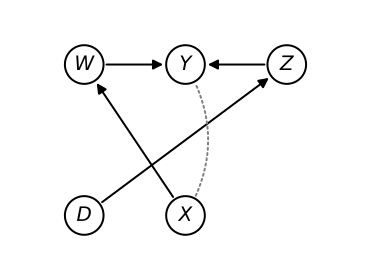

In [4]:
cf_graph_0 = figure_9a.graph
cf_graph_0.draw()

Every endogenous variable gets an exogenous variable, so there are some singletons pointing to the endogenous variables that don't have any bidirected edges.

<img src="images/factual-world.PNG" style="height: 400px" />


The query for this walkthrough `Y @ X` given two interventions, specifically `D` and `X` are being intervened on. Specifically we are intervening on `D` with the observed value of `D`, written here as `-D`, and on `X` with a value we didn't observe `~X` 

In [5]:
query = P(Y @ X | ~X, Z @ D, D)
query

P(Y @ -X | D, +X, Z @ -D)

## First Step: Make Parallel worlds graph

Here we make a parallel worlds graph based on the interventions. Since we have two interventions we create two parallel worlds, represented here by different colors (red for the x intervention and green for the d intervention). The "parallel" variables in each world are connected by unidrected edges.

In [6]:
event = {Y @ -x: -y, X: +x, Z @ -d: -z, D: -d}  # This is the original event we are using
# the input for make_parallel_worlds_graph is a graph and extracted interventions from an event
cf_graph_1 = make_parallel_worlds_graph(figure_9a.graph, {frozenset([-x]), frozenset([-d])})

![Figure9B.PNG](images/parallel-worlds.png)


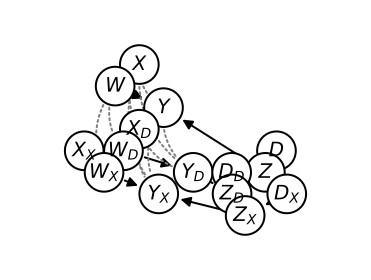

In [7]:
cf_graph_1.draw()  # This is the "Parallel Worlds" graph

## Merging the Parallel Worlds

cf_graph_1 should be a stitched together graph of counterfactual worlds that corresponds to Figure 9b.
Now we will start merging nodes that are equivalent in the two graphs using the topological ordering of (X,D,Z,W,Y)

### First we attmpet to merge `X` and `X  @  X`
Does Lemma 24 hold for X and X @ X?  No it does not, therefore they are not merged.

In [8]:
if lemma_24_holds(cf_graph_1, {Y @ -x: -y, D: -d, Z @ -d: -z, X: +x}, X, X @ X):
    # update the graph by merging the nodes
    cf_graph_2a, preferred_node, eliminated_node = merge_pw(cf_graph_1, X, X @ X)
    # update_event will be run after each merge_pw
    new_event2a = update_event(event, preferred_node, eliminated_node)
else:
    print(f"{X} and {X @ X} cannot be merged")
    # These assignments are to keep things consistent in this walkthrough
    cf_graph_2a = cf_graph_1
    new_event2a = event

X and X @ -X cannot be merged


### Next we succesfully merge `X` and `X  @  D`
Does Lemma 24 hold for X and X @ D?  Yes. Then we merge them together, updating the graph and event to reflect this change.

In [9]:
if lemma_24_holds(cf_graph_2a, {Y @ -x: -y, D: -d, Z @ -d: -z, X: +x}, X, X @ D):
    # update the graph by merging the nodes
    cf_graph_2, preferred_node, eliminated_node = merge_pw(cf_graph_2a, X, X @ D)
    # update_event will be run after each merge_pw
    new_event2 = update_event(new_event2a, preferred_node, eliminated_node)
else:
    print(f"{X} and {X @ D} cannot be merged")
    # These assignments are to keep things consistent in this walkthrough
    cf_graph_2 = cf_graph_2a
    new_event2 = new_event2a
print(f"The updated event is {new_event2}")

The updated event is {Y @ -X: -Y, X: +X, Z @ -D: -Z, D: -D}


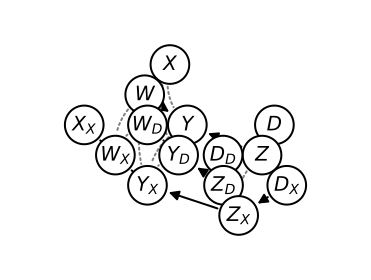

In [10]:
cf_graph_2.draw()  # This is after we have merged any X variables

### Next we merge `D` and `D @  X`, then we attempt to merge `D` and `D @  D`
We find that lemma 24 holds for D and D @ X so we can merge those nodes and update the event. 

Lemma 24 does not hold for D and D @ D, so they are not merged

In [11]:
if lemma_24_holds(cf_graph_2, new_event2, D, D @ -x):
    # update the graph by merging the nodes
    cf_graph_3a, preferred_node, eliminated_node = merge_pw(cf_graph_2, D, D @ -X)
    # update_event will be run after each merge_pw
    new_event3a = update_event(new_event2, preferred_node, eliminated_node)
else:
    print(f"{D} and {D @ X} cannot be merged")
    # These assignments are to keep things consistent in this walkthrough
    cf_graph_3a = cf_graph_2
    new_event3a = new_event2


if lemma_24_holds(cf_graph_3a, new_event3a, D, D @ D):
    # update the graph by merging the nodes
    cf_graph_3, preferred_node, eliminated_node = merge_pw(cf_graph_3a, D, D @ D)
    # update_event will be run after each merge_pw
    new_event3 = update_event(new_event3a, preferred_node, eliminated_node)

else:
    print(f"{D} and {D @ D} cannot be merged")
    # These assignments are to keep things consistent in this walkthrough
    cf_graph_3 = cf_graph_3a
    new_event3 = new_event3a


print(f"The updated event is {new_event3}")

D and D @ -D cannot be merged
The updated event is {Y @ -X: -Y, X: +X, Z @ -D: -Z, D: -D}


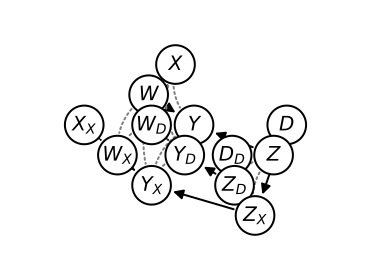

In [12]:
cf_graph_3.draw()  # This is after we have merged any X,D variables

## Figure 11a Checkpoint
At this point our calcualted cf_graph_3 should be equal to the intermediate graph figure_11a graph in (I. Shpitser, J. Pearl 2008).

In [13]:
figure_11a_calculated = cf_graph_3
# figure_11a_calculated.draw()
assert (
    figure_11a_calculated == figure_11a.graph
), "Calculated figure 11a is not equal to the actual figure 11a"
print("Figure 11a calculated is correct")

Figure 11a calculated is correct


![Figure11A.PNG](images/step-2-make-counterfactual.png)


## Merging nodes with different parents

We are allowed to merge certain nodes with different parents if the parents attain the same value. In our case we have `Z, Z @ -d`, and `Z @ -x` with parents `D` and `D @ -d` which attain the same values. This means that we can merge the three `Z` nodes. (notice that `D @ -d` disappears when we merge `Z, Z @ -d`)

In [14]:
# First we merge Z and Z @ X
if lemma_24_holds(cf_graph_3, new_event3, Z, Z @ X):
    # update the graph by merging the nodes
    cf_graph_4a, preferred_node, eliminated_node = merge_pw(cf_graph_3, Z, Z @ X)
    # update_event will be run after each merge_pw
    new_event4a = update_event(new_event3, preferred_node, eliminated_node)
else:
    print(f"{Z} and {Z @ X} cannot be merged")
    # These assignments are to keep things consistent in this walkthrough
    cf_graph_4a = cf_graph_3
    new_event4a = new_event3

Note that `D @ D` is still in the graph

In [15]:
if D @ D in cf_graph_4a.nodes():
    print(f"{D @ D} still in the graph after merging {Z} and {Z @ X}")

D @ -D still in the graph after merging Z and Z @ -X


But next we will merge `Z` and `Z @ D` and see that `D @ D` is removed.

In [16]:
if lemma_24_holds(cf_graph_4a, new_event4a, Z, Z @ D):
    # update the graph by merging the nodes
    cf_graph_4, preferred_node, eliminated_node = merge_pw(cf_graph_4a, Z, Z @ D)
    # update_event will be run after each merge_pw
    new_event4 = update_event(new_event4a, preferred_node, eliminated_node)
else:
    print(f"{Z} and {Z @ D} cannot be merged")
    # These assignments are to keep things consistent in this walkthrough
    cf_graph_4 = cf_graph_4a
    new_event4 = new_event4a

if D @ D not in cf_graph_4.nodes():
    print(f"{D @ D} is not longer found in the graph after merging {Z} and {Z @ D}")

print(f"The updated event is {new_event4}")

D @ -D is not longer found in the graph after merging Z and Z @ -D
The updated event is {Y @ -X: -Y, X: +X, D: -D, Z: -Z}


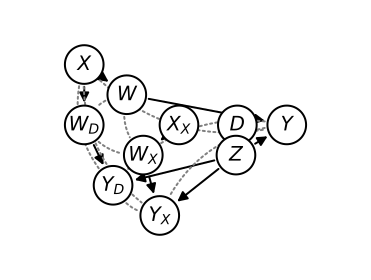

In [17]:
cf_graph_4.draw()  # This is after we have merged any X,D,Z variables

### Next we attempt to merge `W` and `W @ X` and then succesfully merge `W` and `W @ D`

We attempt to merge `W` and `W @ X` but find that lemma 24 does not hold so we move on. 
For `W` and `W @ D` Lemma 24 does hold, so they are merged`

In [18]:
if lemma_24_holds(cf_graph_4, new_event4, W, W @ W):
    # update the graph by merging the nodes
    cf_graph_5a, preferred_node, eliminated_node = merge_pw(cf_graph_4, W, W @ X)
    # update_event will be run after each merge_pw
    new_event5a = update_event(new_event4, preferred_node, eliminated_node)

else:
    print(f"{W} and {W @ X} cannot be merged")
    # These assignments are to keep things consistent in this walkthrough
    cf_graph_5a = cf_graph_4
    new_event5a = new_event4

if lemma_24_holds(cf_graph_5a, new_event5a, W, W @ -d):
    # update the graph by merging the nodes
    cf_graph_5, preferred_node, eliminated_node = merge_pw(cf_graph_5a, W, W @ -d)
    # update_event will be run after each merge_pw
    new_event5 = update_event(new_event5a, preferred_node, eliminated_node)
else:
    print(f"{W} and {W @ -d} cannot be merged")
    # These assignments are to keep things consistent in this walkthrough
    cf_graph_5 = cf_graph_5a
    new_event5 = new_event5a

print(f"The updated event is {new_event5}")

W and W @ -X cannot be merged
The updated event is {Y @ -X: -Y, X: +X, D: -D, Z: -Z}


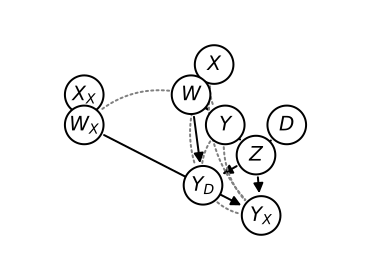

In [19]:
cf_graph_5.draw()  # This is after we have merged any X,D,Z,W variables

## Figure 11b Checkpoint
At this point our calcualted cf_graph_5 should be equal to the intermediate graph figure_11b graph in (I. Shpitser, J. Pearl 2008).

In [20]:
figure_11b_calculated = cf_graph_5
# figure_11b_calculated.draw()
assert (
    figure_11b_calculated == figure_11b.graph
), "Calculated figure 11b is not equal to the actual figure 11b"

print("Figure 11b calculated is correct")

Figure 11b calculated is correct


![Figure11B.PNG](images/step-4-make-counterfactual.PNG)

### Next we (attempt to) merge Y and Y @ X

In [21]:
if lemma_24_holds(cf_graph_5, new_event5, Y, Y @ -x):
    # update the graph by merging the nodes
    cf_graph_6a, preferred_node, eliminated_node = merge_pw(cf_graph_5, Y, Y @ -x)
    # update_event will be run after each merge_pw
    new_event6a = update_event(new_event5, preferred_node, eliminated_node)
else:
    print(f"{Y} and {Y @ -x} cannot be merged")
    # These assignments are to keep things consistent in this walkthrough
    cf_graph_6a = cf_graph_5
    new_event6a = new_event5

Y and Y @ -X cannot be merged


### Next, we merge `Y` and `Y @ -d`
In this case Lemma 24 holds and `Y` and `Y @ D` can be merged

In [22]:
if lemma_24_holds(cf_graph_6a, new_event6a, Y, Y @ -d):
    # update the graph by merging the nodes
    cf_graph_6, preferred_node, eliminated_node = merge_pw(cf_graph_6a, Y, Y @ -d)
    # update_event will be run after each merge_pw
    new_event6 = update_event(new_event6a, preferred_node, eliminated_node)

else:
    print(f"{Y} and {Y @ -d} cannot be merged")
    # These assignments are to keep things consistent in this walkthrough
    cf_graph_6 = cf_graph_6a
    new_event6 = new_event6a
print(f"The updated event is {new_event6}")

The updated event is {Y @ -X: -Y, X: +X, D: -D, Z: -Z}


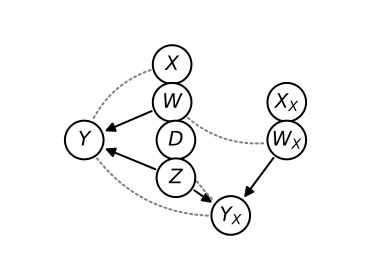

In [23]:
cf_graph_6.draw()  # This is after we have merged any X,D,Z,W,Y variables

## Figure 11c Checkpoint
At this point our calcualted cf_graph_6 should be equal to the intermediate graph figure_11c graph in (I. Shpitser, J. Pearl 2008).

![Figure11C.PNG](images/step-5-make-counterfactual.png)

In [24]:
figure_11c_calculated = cf_graph_6
# display(figure_11c_calculated.draw())

assert (
    figure_11c_calculated == figure_11c.graph
), "Calculated figure 11c is not equal to the actual figure 11c"

print("Figure 11c calculated is correct")

Figure 11c calculated is correct


## Return only the ancestors of events
After having iterated through all the nodes for merging varialbes, the last line of `make-counterfactual-graph()` removes all nodes that are not ancestors of the events $\left\{y_{do(X=x')}, z, d\right\}$. Thus we remove $\{Y, W\}$

In [25]:
# this doesn't quite work yet but I will add it in soon
ancestors = cf_graph_6.ancestors_inclusive(new_event6)
return_graph = cf_graph_6.subgraph(ancestors)

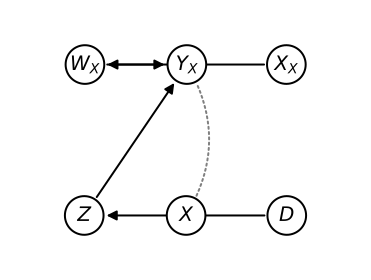

In [26]:
return_graph.draw()  # This is after we have removed the nodes that are not ancestors of the events, i.e. Y and W

## Figure 9c Checkpoint
The walkthrough is finished and our return graph should be equal to the graph figure_9c graph in (I. Shpitser, J. Pearl 2008).

![Figure9C.PNG](images/counterfactual-graph.png)

In [27]:
figure_9c_calculated = return_graph
# figure_9c_calculated.draw()
assert (
    figure_9c_calculated == figure_9c.graph
), "Calculated figure 9c is not equal to the actual figure 9c"
print("Figure 9c calculated is correct")

Figure 9c calculated is correct


## Final Checkpoint
As a final check we will verify that the result from our walkthrough is equal to the result from running make_counterfactual_graph.

In [28]:
final_graph, final_event = make_counterfactual_graph(figure_9a.graph, event)
# figure_9c_calculated.draw()
assert (
    figure_9c_calculated == final_graph
), "Calculated figure 9c from the walkthrough is not equal to running make_counterfactual_graph"
print("The walkthrough graph result is equal to the make_counterfactual_graph result")
assert (
    final_event == new_event6
), "Calculated event from the walkthrough is not equal to running the final_event from make_counterfactual_graph"
print(
    "The resulting event from the walkthrough is equal to the final_event from make_counterfactual_graph"
)

The walkthrough graph result is equal to the make_counterfactual_graph result
The resulting event from the walkthrough is equal to the final_event from make_counterfactual_graph


# More Examples of make_counterfactual_graph
Here are four more counterfactual graphs that could be created from figure_9a.graph with different input events

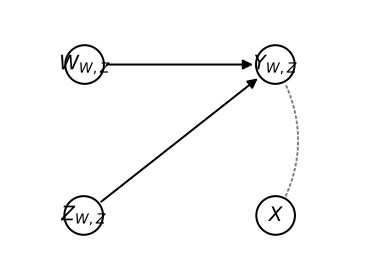

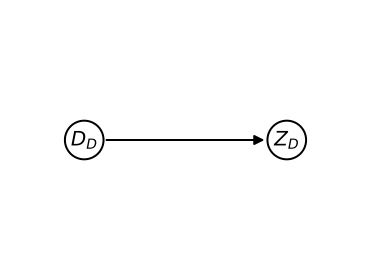

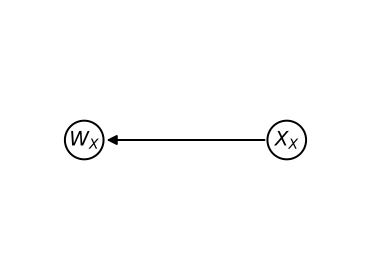

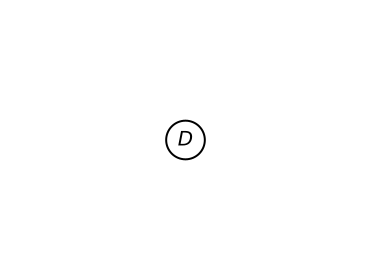

In [31]:
input_events = [{Y @ (-w, -z): -y, X @ (-w, -z): -x}, {Z @ -d: -z}, {W @ -x: -w}, {D: -d}]
for input_event in input_events:
    actual_graph, actual_event = make_counterfactual_graph(figure_9a.graph, input_event)
    actual_graph.draw()
    plt.show()

In [29]:
graph, event = make_counterfactual_graph(
    tikka_unidentifiable_graph.graph, {Y @ -x: -y, X: +x, Z @ -d: -z, D: -d, Y: -y}
)
graph.draw()
event

NameError: name 'tikka_unidentifiable_graph' is not defined